In my last post, I wrote about using burnside's lemma to count the number of unique ways beads could be arranged if strung on a bracelet. After writing the post, I had two other questions: how many unique possible chords could be played using the Western 12-note scale? And, as someone who listens to a lot of music, it is likely that I have heard every possible chord which can be composed?

The question of how many unique notes could be played using the 12-note scale was fairly easy. I simply considered each note orientation to be a necklace (allowing rotations but not reflections) with 12 possible beads. I considered notes that were played to be of one color, and notes that were not played to be of a different color. 

In [26]:
using Combinatorics
function comb(n, k)
    return factorial(n) / factorial(k) / factorial(n - k)
end

comb (generic function with 1 method)

In [27]:

n_orientations_0_1_11_12 = 1 ## there is only one way to play all notes, play one note, or leave one note out.

print("There are ", Int(n_orientations_0_1_11_12), " unique orientations in which 0, 1, 11, or 12 notes can be played")

## 2/10
n_orientations_2_10 = (comb(12, 2) + 6)/ 12 # at 6 o clock, there are 6 different fixed points
print(", ", Int(n_orientations_2_10), " unique orientations in which 2/10 notes can be played")

## 3 / 9
n_orientations_3_9 = (comb(12, 3) + 4*2)/ 12
print(", ", Int(n_orientations_3_9), " unique orientations in which 3/9 notes can be played")


## 4/8
n_orientations_4_8 = (comb(12, 4) + 
    comb(6, 2) + #rotation at half
    3*2 #at 3 and 9 o clock there are 3 possible combinations
    )/ 12
print(", ", Int(n_orientations_4_8), " unique orientations in which 4/8 notes can be played")

## 5/7
n_orientations_5_7 = (comb(12, 5))/ 12 ## no way for there to be any fixed points beyond the null

print(", ", Int(n_orientations_5_7), " unique orientations in which 5/7 notes can be played")

n_orientations_6 = (comb(12, 6) + 
    2 * 2 + #2, and 10 o clock both have 2 choices
    comb(4, 2) * 2 + #4 and 8 o clock rotations can distribute 1/3 the beads (2) among 4 possible slots
    
    comb(6, 3) # 6 o clock can distribute 3 beads among 6 possible slots
    )/ 12
print(", and ", Int(n_orientations_6), " unique orientations in which 6 notes can be played")
println("")
println("In total, there are ", Int(n_orientations_0_1_11_12 * 4 + (
             n_orientations_2_10 
            + n_orientations_3_9 
            + n_orientations_4_8
            + n_orientations_5_7) * 2 + n_orientations_6), " orientations in which any number of notes can be played ")

There are 1 unique orientations in which 0, 1, 11, or 12 notes can be played, 6 unique orientations in which 2/10 notes can be played, 19 unique orientations in which 3/9 notes can be played, 43 unique orientations in which 4/8 notes can be played, 66 unique orientations in which 5/7 notes can be played, and 80 unique orientations in which 6 notes can be played
In total, there are 352 orientations in which any number of notes can be played 


My second question of "it is likely that I have heard every possible chord which can be composed?" was more difficult to answer. Eventually I found the [musicnet](https://zenodo.org/record/5120004#.ZEP5Mi-B3BI) dataset, which was originally designed for training musicala ML models, but which had some labels which could be used to answer my question. 

First, I'll write a function to read the labels from the musicnet dataset into one dataframe:

In [31]:
using CSV
using DataFrames
"""
Read musicnet notes data from all songs into one dataframe
"""
function read_all_notes_data(labels_input_dir::String = "/Volumes/SanDisk/julia_testing/frequency_chords/musicnet", 
        metadata_input_dir::String = "/Volumes/SanDisk/julia_testing/frequency_chords/musicnet_metadata.csv")
    dataframe_list = []
    track_names = CSV.read(metadata_input_dir, DataFrame)
    
    for labels_dir = ["train_labels", "test_labels"]
        current_dir = labels_input_dir * "/" * labels_dir
        for csv_file in readdir(current_dir)
            if string(csv_file)[1] == '.'
                continue
            end
            current_df = CSV.read(current_dir * "/" * csv_file, DataFrame)
            insertcols!(current_df, "id" => parse(Int, csv_file[1:4]))
            push!(dataframe_list, current_df)
        end
    end
    full_dataframe = dataframe_list[1]
    for i in 2:length(dataframe_list)
        full_dataframe = vcat(full_dataframe, dataframe_list[i])
    end
    full_dataframe = leftjoin(full_dataframe, track_names, on = :id)
    return full_dataframe
        
end

read_all_notes_data

Our resulting dataframe has a column "note" which contains an integer corresponding to the note which was played at a given time. "start_time" and "end_time" tell us when the note started and stopped being played. A "chord" may be defined a group of notes which all start at the same time. However, it could also be defined as a group of notes that are all being played at the same time. We'll look at the frequencies that chords have been played in both of these ways. 


However, before we can easily count up the frequencies of chords from this dataframe, we need to first get note a set of integer notes into a single "chord". We want to make sure that the set of notes are transformed into the same chord regardless of whether the chord is transposed (i.e., a single integer is added to every note in the list) or if the chord was modulated (i.e., a note in the chord is replaced with a note in the chord from a different octave).

I'll do this by defining a function *get_aligned_chord* that takes a set of notes and returns a given chord orientation in the same orientation every time, regardless of transpositions or modulations. I'll need a couple of other helper functions to do this.

In [47]:
"""
Take a list of notes, and get the number of "unique" notes, 
so notes in different octaves are considered the "same" note. 
Also, account for transpositions of the same chord by making each returned note set start at 0
""" 
function get_unique_notes(note_set::Vector{Int64})
    unique_notes = unique(note_set .% 12)
    return sort(unique_notes .- minimum(unique_notes))
end

"""
Get the "gaps" between each note and the next note in a set. 
""" 
function get_note_gaps(note_set::Vector{Int64})
    ## Get the gaps that happen after each note
    vcat(note_set[2:length(note_set)], [12]) - note_set
end
"""
Score the gaps of a note list.
""" 
function gap_score(gap_list::Vector{Int64})
    score = 0
    for gap in gap_list
        score = score * 10 + gap
    end
    return score
end
"""
Get an aligned chord orientation corresponding to a note set.

This orientation will be the same even if a note set were transposed 
(i.e., by adding an integer to each note), and it only conntains notes in one octave starting at zero
""" 
function get_aligned_chord(note_set::Vector{Int64})
    note_set_unique = get_unique_notes(note_set)
    possible_orientations = [get_unique_notes((note_set_unique .+  i)) for i in 1:12]
    gaps_lists = [get_note_gaps(orientation) for orientation in possible_orientations]
    gap_scores = [gap_score(gap_list) for gap_list in gaps_lists]
    return string(possible_orientations[argmin(gap_scores)])
end

get_aligned_chord

And lastly, I'll define a function that creates a frequency table dataframe from a list of chords. These chord frequencies will be the thing that we will eventually use to answer our question.

In [ ]:
using DataFrames, FreqTables
function freqtable_as_df(notes_list::Vector{String}, song_id::Int)
    temp_freqtable = freqtable(notes_list)
    output_df = DataFrame(values = names(temp_freqtable)[1], frequencies = Vector(temp_freqtable))
    output_df[!,:song_id] .= song_id
    return output_df
end

Finally, we can look at the different chords that have appeared in music pieces. We will look at notes, start times, and end times for each song in our dataset, and look at chords as defined by notes with the same start time, and notes whose start/end times overlap with another note's end time.

In [45]:
using DataFrames
chords_df = DataFrame()
chords_overlapping_df = DataFrame()


for song_id in unique(notes_df.id)
    ## defining a chord as a set of notes that all start at the same time
    unique_chord_list = [
        get_aligned_chord(notes_df[(notes_df.id .== song_id) .& (notes_df.start_time .== start_time),:note]) 
        for start_time in 
            unique(notes_df[(notes_df.id .== song_id) ,:start_time])
    ]

    chords_df = vcat(chords_df, freqtable_as_df(unique_chord_list, song_id))
    
    unique_chord_list_overlapping = [
        get_aligned_chord(
            notes_df[(notes_df.id .== song_id) .& 
                     (notes_df.start_time .<= start_time) .& 
                     (notes_df.end_time .>= start_time),:note]
            ) 
        for start_time in 
            unique(notes_df[(notes_df.id .== song_id) ,:start_time])
    ]
    
    
    ## defining a chord as a set of notes that are all played at the same time, but which may not all start at the same time

    chords_overlapping_df = vcat(chords_overlapping_df, freqtable_as_df(unique_chord_list_overlapping, song_id))
    
end

LoadError: UndefVarError: notes_df not defined

In [48]:
## don't put this one in the post, this just saves on time for making these graphs
function transform_ids(df)
    df[!,"old_chords"] = df.values
    df.values = [ 
        get_aligned_chord(
        [parse(Int, replace(x, r"\D"=> "")) for x in split(chord_str, ",")]
            )
        
        for chord_str in df[!,"old_chords"]]
    return df
end

transform_ids (generic function with 1 method)

In [50]:
using CSV
musicnet_metadata = CSV.read("/Volumes/SanDisk/julia_testing/frequency_chords/musicnet_metadata.csv", DataFrame)
chords_df = leftjoin(chords_df, musicnet_metadata, on = :song_id=>:id)
chords_df_overlapping = leftjoin(chords_df_overlapping, musicnet_metadata, on = :song_id=>:id)


,values,frequencies,song_id,old_chords,composer
,String,Int64,Int64,String31,String15?
1,"[0, 1, 2, 6, 7]",2,1727,"[0, 1, 2, 6, 7]",Schubert
2,"[0, 1, 3, 4, 6, 8, 9]",2,1727,"[0, 1, 3, 4, 6, 8, 9]",Schubert
3,"[0, 1, 3, 4, 6, 8]",6,1727,"[0, 1, 3, 4, 6, 8]",Schubert
4,"[0, 1, 3, 4, 6, 9]",4,1727,"[0, 1, 3, 4, 6, 9]",Schubert
5,"[0, 1, 3, 4, 6]",2,1727,"[0, 1, 3, 4, 6]",Schubert
6,"[0, 1, 3, 4, 7, 8]",4,1727,"[0, 1, 3, 4, 7, 8]",Schubert
7,"[0, 1, 3, 4, 8]",5,1727,"[0, 1, 3, 4, 8]",Schubert
8,"[0, 1, 3, 5, 6, 8, 10]",1,1727,"[0, 1, 3, 5, 6, 8, 10]",Schubert
9,"[0, 1, 3, 5, 6, 8]",31,1727,"[0, 1, 3, 5, 6, 8]",Schubert


In [247]:
values_dict = Dict()

values_dict[get_aligned_chord([0, 4, 10])] = "Augmented Sixth (Italian)"
values_dict[get_aligned_chord([0, 4, 6, 10])] = "Augmented Sixth (French)"
values_dict[get_aligned_chord([0, 4, 7, 10])] = "Augmented Sixth (German)"
values_dict[get_aligned_chord([0, 4, 7, 10, 2, 6])] = "Augmented Eleventh"
values_dict[get_aligned_chord([0, 4, 8, 11])] = "Augmented Major Seventh"
values_dict[get_aligned_chord([0, 4, 8, 10])] = "Augmented Seventh"
values_dict[get_aligned_chord([0, 3, 6, 11])] = "Diminished Major Seventh"
values_dict[get_aligned_chord([0, 3, 6, 9])] = "Diminished Seventh"
values_dict[get_aligned_chord([0, 4, 7])] = "Dominant"
values_dict[get_aligned_chord([0, 4, 7, 10, 2, 5])] = "Dominant Eleventh"
values_dict[get_aligned_chord([0, 4, 7, 10, 1])] = "Dominant Minor Ninth"
values_dict[get_aligned_chord([0, 4, 7, 10, 2])] = "Dominant Ninth"
values_dict[get_aligned_chord([0, 3, 7])] = "Dominant Parallel"
values_dict[get_aligned_chord([0, 4, 7, 10])] = "Dominant Seventh"
values_dict[get_aligned_chord([0, 4, 6, 10])] = "Dominant Seventh Flat Five"
values_dict[get_aligned_chord([0, 4, 7, 10, 3])] = "Dominant Seventh Sharp Nine"
values_dict[get_aligned_chord([0, 4, 7, 10, 2, 5, 9])] = "Dominant Thirteenth"
values_dict[get_aligned_chord([0, 5, 6, 7])] = "Dream"
values_dict[get_aligned_chord([0, 7, 9, 1, 4])] = "Elektra"
values_dict[get_aligned_chord([0, 8, 11, 4, 9])] = "Farben"
values_dict[get_aligned_chord([0, 3, 6, 10])] = "Half Diminished Seventh Chord"
values_dict[get_aligned_chord([0,4, 7, 10])] = "Harmonic Seventh Chord"
values_dict[get_aligned_chord([0,3, 6])] = "Leading Tone Triad"
values_dict[get_aligned_chord([0,4, 7, 11, 6])] = "Lydian"
values_dict[get_aligned_chord([0, 1, 5, 6, 10, 0, 3, 5])] = "Magic"
values_dict[get_aligned_chord([0, 4, 7, 11, 2, 5])] = "Major Eleventh"
values_dict[get_aligned_chord([0, 4, 8, 11, 6])] = "Major Seventh Sharp Eleventh"
values_dict[get_aligned_chord([0, 4, 7, 9])] = "Major Sixth"
values_dict[get_aligned_chord([0, 4, 7, 9, 2])] = "Major Sixth Ninth"
values_dict[get_aligned_chord([0, 4, 7, 11, 2])] = "Major Ninth"
values_dict[get_aligned_chord([0, 4, 7, 11, 2, 6, 9])] = "Major Thirteenth"
values_dict[get_aligned_chord([0, 3, 7])] = "Mediant"
values_dict[get_aligned_chord([0, 3, 7, 10, 2, 5])] = "Minor Eleventh"
values_dict[get_aligned_chord([0, 3, 7, 11])] = "Minor Major Seventh"
values_dict[get_aligned_chord([0, 3, 7, 10, 2])] = "Minor Ninth"
values_dict[get_aligned_chord([0, 3, 7, 9])] = "Minor Sixth"
values_dict[get_aligned_chord([0, 3, 7, 9, 2])] = "Minor Sixth Ninth"
values_dict[get_aligned_chord([0, 3, 7, 10, 2, 5, 9])] = "Minor Thirteenth Chord"
values_dict[get_aligned_chord([0, 6, 10, 4, 9, 2])] = "Mystic"
values_dict[get_aligned_chord([1, 5, 8])] = "Neapolitan"
values_dict[get_aligned_chord([0, 4, 8, 10, 2])] = "Ninth Augmented Fifth"
values_dict[get_aligned_chord([0, 4, 6, 10, 2])] = "Ninth Flat Fifth"
values_dict[get_aligned_chord([1, 2, 8, 0, 3, 6, 7, 10, 11, 4, 7])] = "Northern Lights"
values_dict[get_aligned_chord([0, 1, 4, 5, 8, 9])] = "Ode To Napoleon"
values_dict[get_aligned_chord([0, 1, 4, 6, 7, 10])] = "Petrushka"
values_dict[get_aligned_chord([0, 7])] = "Power Chord"
values_dict[get_aligned_chord([0, 3, 7])] = "Psalms Chord"
values_dict[get_aligned_chord([0, 4, 7])] = "Secondary Dominant"
values_dict[get_aligned_chord([0, 3, 6])] = "Secondary Leading Tone"
values_dict[get_aligned_chord([0, 3, 7])] = "Secondary Supertonic"
values_dict[get_aligned_chord([0, 4, 7, 9, 10])] = "Seven Six"
values_dict[get_aligned_chord([0, 5, 7, 10])] = "Seventh Suspension"
values_dict[get_aligned_chord([0, 5, 7, 10, 3])] = "So What"
values_dict[get_aligned_chord([0, 5, 7])] = "Suspended"
values_dict[get_aligned_chord([0, 4, 7])] = "Subdominant"
values_dict[get_aligned_chord([0, 3, 7])] = "Subdominant Parallel"
values_dict[get_aligned_chord([0, 4, 7])] = "Subtonic"
values_dict[get_aligned_chord([0, 3, 7])] = "Supertonic"
values_dict[get_aligned_chord([0, 4, 7])] = "Tonic"
values_dict[get_aligned_chord([0, 3, 7])] = "Tonic parallel"
values_dict[get_aligned_chord([0, 3, 6, 10])] = "Tristan"
values_dict[get_aligned_chord([0, 6, 7])] = "Viennese Trichord 2"
values_dict[get_aligned_chord([0, 1, 6])] = "Viennese Trichord"
values_dict[get_aligned_chord([0,3,5])] = "Blues trichord"

## These ones come last because their names seem more common
values_dict["[0]"] = "Single Tone"
values_dict["[0, 1]"] = "Minor Second"
values_dict["[0, 2]"] = "Major Second"
values_dict["[0, 3]"] = "Minor Third"
values_dict["[0, 4]"] = "Major Third"
values_dict["[0, 5]"] = "Fourth"
values_dict["[0, 6]"] = "Diminished Fifth"
values_dict[get_aligned_chord([0, 4, 9])] = "Minor Triad"
values_dict[get_aligned_chord([0, 5, 7])] = "Suspended 4"
values_dict[get_aligned_chord([0, 2, 7])] = "Suspended 2"
values_dict[get_aligned_chord([0, 4, 7])] = "Major Triad"
values_dict[get_aligned_chord([0, 4, 8])] = "Diminished Triad"
values_dict[get_aligned_chord([0, 5, 10])] = "Augmented Triad"
values_dict[get_aligned_chord([0, 4, 7, 11])] = "Major 7th"
values_dict[get_aligned_chord([0, 4, 7, 10])] = "Dominant 7th"
values_dict[get_aligned_chord([0, 3, 7, 10])] = "Minor 7th"
values_dict[get_aligned_chord([0, 3, 6, 9])] = "Diminished 7th"
values_dict[get_aligned_chord([0, 4, 7, 9])] = "Add 6"





"Add 6"

In [248]:
function most_common_chords(input_df)
    aggregated_df =  combine(groupby(input_df, :values), :frequencies => sum => :sum_freq)
    aggregated_df[!,"proportion_of_chords"] = aggregated_df.sum_freq ./ sum(aggregated_df.sum_freq)
    sort!(aggregated_df,  :sum_freq, rev = true)
    aggregated_df[!,"chord_name"] = [
    if chord in keys(values_dict) values_dict[chord] else chord end
    for chord in aggregated_df.values
            ]
    
    return aggregated_df
end

most_common_chords (generic function with 1 method)

In [249]:
aggregated_df = most_common_chords(
    chords_df_overlapping[chords_df_overlapping[!,"composer"] .== "Bach",:]
)
aggregated_df[1:10,:]

,values,sum_freq,proportion_of_chords,chord_name
,String,Int64,Float64,String
1,"[0, 2]",6114,0.122899,Major Second
2,"[0, 3]",4112,0.0826566,Minor Third
3,[0],4109,0.0825963,Single Tone
4,"[0, 1]",3897,0.0783348,Minor Second
5,"[0, 4]",2643,0.0531278,Major Third
6,"[0, 5]",2459,0.0494291,Fourth
7,"[0, 3, 8]",1482,0.0297901,Major Triad
8,"[0, 3, 7]",1281,0.0257498,Minor Triad
9,"[0, 2, 4]",1069,0.0214883,"[0, 2, 4]"


In [250]:
aggregated_df = most_common_chords(
    chords_df_overlapping[chords_df_overlapping[!,"composer"] .== "Beethoven",:]
)
aggregated_df[1:10,:]

,values,sum_freq,proportion_of_chords,chord_name
,String,Int64,Float64,String
1,"[0, 3, 8]",35018,0.120902,Major Triad
2,[0],24425,0.0843288,Single Tone
3,"[0, 3, 7]",17909,0.0618319,Minor Triad
4,"[0, 4]",17292,0.0597017,Major Third
5,"[0, 3]",16486,0.0569189,Minor Third
6,"[0, 5]",13326,0.0460088,Fourth
7,"[0, 2, 6, 9]",12931,0.0446451,Dominant 7th
8,"[0, 2]",12891,0.044507,Major Second
9,"[0, 1]",9205,0.0317808,Minor Second


In [251]:
aggregated_df = most_common_chords(
    chords_df_overlapping[chords_df_overlapping[!,"composer"] .== "Mozart",:]
)
aggregated_df[1:10,:]

,values,sum_freq,proportion_of_chords,chord_name
,String,Int64,Float64,String
1,"[0, 3, 8]",4523,0.124852,Major Triad
2,[0],2586,0.0713832,Single Tone
3,"[0, 2, 6, 9]",2105,0.0581058,Dominant 7th
4,"[0, 4]",1789,0.0493831,Major Third
5,"[0, 3]",1664,0.0459326,Minor Third
6,"[0, 3, 7]",1496,0.0412952,Minor Triad
7,"[0, 5]",1208,0.0333453,Fourth
8,"[0, 2]",1193,0.0329312,Major Second
9,"[0, 1]",1010,0.0278798,Minor Second


In [252]:
chords_df_overlapping_thirds = chords_df_overlapping[
    [count(",", notes_string) for notes_string in chords_df_overlapping.values] .== 2,:]
chords_df_overlapping_thirds = chords_df


for composer in unique(chords_df_overlapping[!,"composer"])

        aggregated_df = most_common_chords(
                chords_df_overlapping_thirds[
                    (chords_df_overlapping_thirds[!,"composer"] .== composer) ,:]
                )
        println(composer)
        println(aggregated_df[1:10,:])
        

    
end

Schubert
10×4 DataFrame
 Row │ values        sum_freq  proportion_of_chords  chord_name             
     │ String        Int64     Float64               String                 
─────┼──────────────────────────────────────────────────────────────────────
   1 │ [0]              35420             0.553965   Single Tone
   2 │ [0, 3, 8]         5512             0.0862072  Major Triad
   3 │ [0, 3]            4705             0.0735858  Minor Third
   4 │ [0, 4]            4301             0.0672672  Major Third
   5 │ [0, 3, 7]         2358             0.0368789  Minor Triad
   6 │ [0, 5]            2275             0.0355808  Fourth
   7 │ [0, 2, 6, 9]      1934             0.0302476  Dominant 7th
   8 │ [0, 2]            1152             0.0180172  Major Second
   9 │ [0, 3, 6]          859             0.0134347  Secondary Leading Tone
  10 │ [0, 2, 9]          783             0.012246   Blues trichord
Mozart
10×4 DataFrame
 Row │ values        sum_freq  proportion_of_chords  chord_nam

In [241]:
chords_df_overlapping_thirds = chords_df_overlapping[
    [count(",", notes_string) for notes_string in chords_df_overlapping.values] .== 2,:]
#chords_df_overlapping_thirds = chords_df_overlapping
proportion_major_list = []
proportion_minor_list = []
proportion_major_of_all_list = []
proportion_minor_of_all_list = []
composer_list = []
song_id_list = []

for composer in unique(chords_df_overlapping[!,"composer"])
    for song_id in unique(chords_df_overlapping[chords_df_overlapping[!,"composer"] .== composer, "song_id"])
        

        aggregated_df = most_common_chords(
                chords_df_overlapping_thirds[
                    (chords_df_overlapping_thirds[!,"composer"] .== composer) .&
                    (chords_df_overlapping_thirds[!,"song_id"] .== song_id),:]
                )
        if ("Major Triad" in aggregated_df.chord_name ) & ("Minor Triad" in aggregated_df.chord_name )

            major_triad_prop = aggregated_df[(aggregated_df.chord_name .== "Major Triad"), "proportion_of_chords"][1]
            minor_triad_prop = aggregated_df[(aggregated_df.chord_name .== "Minor Triad"), "proportion_of_chords"][1]
            push!(proportion_major_list, major_triad_prop / minor_triad_prop)
            push!(proportion_major_of_all_list, major_triad_prop)
            push!(proportion_minor_of_all_list, minor_triad_prop)
            push!(proportion_minor_list, minor_triad_prop/ major_triad_prop )
            
            push!(composer_list, composer)
            push!(song_id_list, song_id)
        end
        
    end
    
end

In [229]:
prop_major_df = DataFrame(proportion_major = proportion_major_list, 
    composer = composer_list, 
    song_id = song_id_list,
    proportion_major_of_all = proportion_major_of_all_list,
    proportion_minor_of_all = proportion_minor_of_all_list,
    proportion_minor = proportion_minor_list)

,proportion_major,composer,song_id,proportion_major_of_all,proportion_minor_of_all
,Any,Any,Any,Any,Any
1,1.30992,Schubert,1727,0.363532,0.277523
2,10.12,Schubert,1728,0.695055,0.0686813
3,7.66216,Schubert,1729,0.521619,0.0680773
4,2.65909,Schubert,1730,0.535878,0.201527
5,0.568182,Schubert,1733,0.144231,0.253846
6,9.925,Schubert,1734,0.617418,0.0622084
7,4.68125,Schubert,1735,0.467541,0.0998752
8,7.32609,Schubert,1739,0.456022,0.0622463
9,1.43434,Schubert,1742,0.363636,0.253521


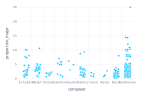

In [230]:
using Gadfly
plot(prop_major_df, x = :composer, y = :proportion_major,
    Stat.x_jitter(range=0.5),
    Geom.point#, Scale.y_log10
)

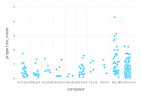

In [231]:
using Gadfly
plot(prop_major_df, x = :composer, y = :proportion_minor,
    Stat.x_jitter(range=0.5),
    Geom.point#, Scale.y_log10
)

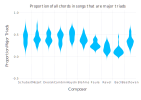

In [232]:
using Gadfly
plot(prop_major_df, x = :composer, y = :proportion_major_of_all,
    
    Guide.xlabel( "Composer"),
    Guide.ylabel( "Proportion Major Triads"),
    Guide.title( "Proportion of all chords in songs that are major triads"),
    #alpha = [.3 for x in prop_major_df.composer],
    #Stat.x_jitter(range=0.5),
    #Geom.point,
    Geom.violin, 
    
    
)

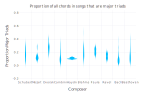

In [233]:
using Gadfly
plot(prop_major_df, x = :composer, y = :proportion_minor_of_all,
    
    Guide.xlabel( "Composer"),
    Guide.ylabel( "Proportion Major Triads"),
    Guide.title( "Proportion of all chords in songs that are major triads"),
    #alpha = [.3 for x in prop_major_df.composer],
    #Stat.x_jitter(range=0.5),
    #Geom.point,
    Geom.violin, 
    
    
)

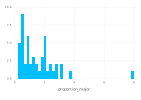

In [163]:
plot(prop_major_df[prop_major_df.composer .== "Bach",:], x = :proportion_major, Geom.histogram)

In [167]:
sum(prop_major_df[prop_major_df.composer .== "Bach","proportion_major"] .< 1) 



22

In [176]:
 println(prop_major_df[prop_major_df.proportion_major .< .5,:])

8×3 DataFrame
 Row │ proportion_major  composer   song_id 
     │ Any               Any        Any     
─────┼──────────────────────────────────────
   1 │ 0.361111          Bach       2208
   2 │ 0.232558          Bach       2209
   3 │ 0.448276          Bach       2230
   4 │ 0.318182          Bach       2282
   5 │ 0.333333          Bach       2304
   6 │ 0.375             Bach       2305
   7 │ 0.448617          Beethoven  2390
   8 │ 0.44227           Beethoven  2393


In [173]:
 println(prop_major_df[prop_major_df.proportion_major .> 20,:])
most_common_chords(
                chords_df_overlapping_thirds[
                    (chords_df_overlapping_thirds[!,"song_id"] .== prop_major_df[prop_major_df.proportion_major .> 20,:song_id]),:]
                )



1×3 DataFrame
 Row │ proportion_major  composer   song_id 
     │ Any               Any        Any     
─────┼──────────────────────────────────────
   1 │ 25.0              Beethoven  2538


,values,sum_freq,proportion_of_chords,chord_name
,String,Int64,Float64,String
1,"[0, 3, 8]",125,0.154895,Major Triad
2,"[0, 4]",121,0.149938,Major Third
3,[0],118,0.146221,Single Tone
4,"[0, 5]",83,0.10285,Fourth
5,"[0, 2]",70,0.086741,Major Second
6,"[0, 3]",35,0.0433705,Minor Third
7,"[0, 2, 6, 9]",32,0.039653,Dominant 7th
8,"[0, 3, 6]",23,0.0285006,"[0, 3, 6]"
9,"[0, 1, 8]",22,0.0272615,"[0, 1, 8]"


In [168]:
sum(prop_major_df[prop_major_df.composer .== "Bach","proportion_major"] .> 1) 

26

In [119]:
unique(chords_df_overlapping[!,"composer"])

10-element Vector{Union{Missing, String15}}:
 "Schubert"
 "Mozart"
 "Dvorak"
 "Cambini"
 "Haydn"
 "Brahms"
 "Faure"
 "Ravel"
 "Bach"
 "Beethoven"

In [55]:
most_common_chords(chords_df)

,values,sum_freq
,String,Int64
1,[0],312588
2,"[0, 3]",46764
3,"[0, 4]",38711
4,"[0, 3, 8]",33513
5,"[0, 5]",20556
6,"[0, 3, 7]",15213
7,"[0, 2]",10031
8,"[0, 2, 6, 9]",9106
9,"[0, 3, 6]",8707


In [49]:
using CSV
chords_df_overlapping = CSV.read("chords_overlapping_df.csv", DataFrame)
chords_df = CSV.read("chords_df.csv", DataFrame)

chords_df_overlapping = transform_ids(chords_df_overlapping)
chords_df = transform_ids(chords_df)

,values,frequencies,song_id,num_notes,old_chords
,String,Int64,Int64,Int64,String31
1,"[0, 1, 3, 5]",6,1727,4,"[0, 1, 3, 5]"
2,"[0, 1, 3, 6, 8]",22,1727,5,"[0, 1, 3, 6, 8]"
3,"[0, 1, 3, 6, 9]",9,1727,5,"[0, 1, 3, 6, 9]"
4,"[0, 1, 3, 6]",6,1727,4,"[0, 1, 3, 6]"
5,"[0, 1, 3, 7]",2,1727,4,"[0, 1, 3, 7]"
6,"[0, 1, 4, 7]",2,1727,4,"[0, 1, 4, 7]"
7,"[0, 1, 5]",2,1727,3,"[0, 1, 5]"
8,"[0, 1]",1,1727,2,"[0, 1]"
9,"[0, 1, 4, 10]",6,1727,4,"[0, 2, 3, 6]"
